## Compare Step-Index computations

### Imports

In [131]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

import gc
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.transforms import fourier_transform
from mmfsim.devices import MockDeformableMirror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Input variables

In [132]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 3 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.4665, n2=1.45)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [133]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.4665
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.219
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46641487  0.          0.          1.        ]
 [ 1.46628389  2.          1.          1.        ]
 [ 1.46611179  4.          2.          1.        ]
 [ 1.46605151  1.          0.          2.        ]
 [ 1.46590084  6.          3.          1.        ]
 [ 1.46577563  3.          1.          2.        ]
 [ 1.46565244  8.          4.          1.        ]
 [ 1.46545734  5.          2.          2.        ]
 [ 1.46539799  2.          0.          3.        ]
 [ 1.46536754 10.          5.          1.        ]]


In [134]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

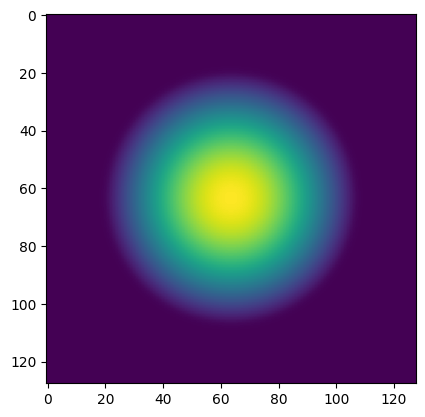

In [135]:
plt.imshow(fiber._modes[:, :, 0, 0]) # Display the last guided mode found that has a refractive index above the cladding index

### Define fitness and helpful functions

In [136]:
from waveoptics.metrics.numpy import quality, pearson

def make_diagonal_mode_coupling_matrix(fiber, fiber_length) -> np.ndarray:
    prop_constants = fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
    print(prop_constants.shape)

    degen_betas = np.zeros(shape=(fiber._N_modes_degen))
    k = 0
    for i in range(fiber._N_modes):
        if prop_constants[i, 2] == 0: # Mode is centro-symmetric
            degen_betas[k] = prop_constants[i, 0]
            k += 1
        else: # Mode is not centro-symmetric
            degen_betas[k] = prop_constants[i, 0]
            degen_betas[k+1] = prop_constants[i, 0]
            k += 2

    propagation_matrix = np.diag(np.exp(-1j * degen_betas * fiber_length))
    return propagation_matrix

def generate_deformed_input_beam(phi) -> np.ndarray:
    # phase = LinearPhase(grid)
    # phase.compute(coeffs=[0.5e-4, 1])

    beam = GaussianBeam(grid)
    beam.compute(amplitude=1, width=fiber.radius/2, centers=[0, 0])
    beam.field = np.complex64(fiber._modes[:, :, 0, 0])
    # beam.add_phase(phase.phase)
    beam.normalize_by_energy()

    phi = np.insert(phi, 0, 0)
    n2 = phi.size
    n = int(np.sqrt(phi.size))
    phase_map = phi.reshape(n, n)

    dm = MockDeformableMirror(pixel_size=grid.pixel_size, pixel_numbers=grid.pixel_numbers, diameter=2.4*fiber.radius, offsets=(0*fiber.radius, 0))
    dm.apply_phase_map(phase_map)


    beam.field *= dm._field_matrix
    return beam.field


def couple_input_beam(field):
    coupled_in = StepIndexFiberDegenCoupler(field, grid, fiber, N_modes=fiber._N_modes_degen)
    return coupled_in


def propagate(coupled_in, propagation_matrix) -> np.ndarray:
    new_coeffs = propagation_matrix @ coupled_in.modes_coeffs

    coupled_out = deepcopy(coupled_in)
    coupled_out.modes_coeffs = new_coeffs
    coupled_out.recompose()

    return coupled_out



def get_output_field_from_phases(phi, propagation_matrix):
    field = generate_deformed_input_beam(phi)
    coupled_in = couple_input_beam(field)
    coupled_out = propagate(coupled_in, propagation_matrix)
    return coupled_out


def fitness_function_from_phases(phi, target_field, propagation_matrix):
    coupled_out = get_output_field_from_phases(phi, propagation_matrix)
    # loss = -quality(coupled_out.field, target_field, squared=False)
    # loss = -pearson(coupled_out.field, target_field)
    loss = -np.square(np.abs(coupled_out.modes_coeffs[0]))
    return loss


### Optimize using CMA-ES

(<Figure size 1500x500 with 2 Axes>, <Axes: >)

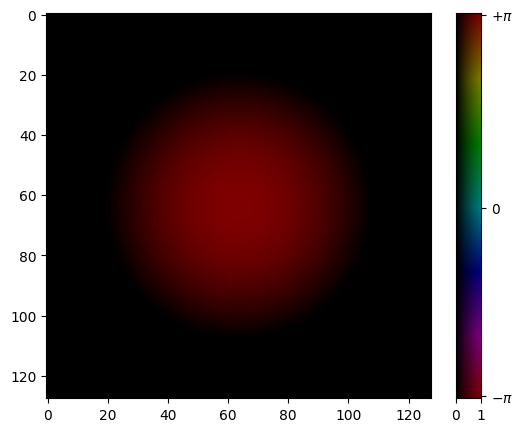

In [137]:
from waveoptics.plots.plots import complex_imshow

target_field = np.complex64(fiber._modes[:, :, 0, 0])

complex_imshow(target_field)

In [138]:
import cma

propagation_matrix = make_diagonal_mode_coupling_matrix(fiber, fiber_length=1)

n = 8
phi0 = 2 * np.pi * np.random.rand(1, n**2 - 1) * 0
es = cma.CMAEvolutionStrategy(
    x0=phi0.flatten(),
    sigma0= np.pi / 3,
    options={
        'bounds': [-np.pi, +np.pi],
        # 'popsize': 20,
    },
)
es.optimize(fitness_function_from_phases, iterations=10, args=(target_field, propagation_matrix))

# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

(140, 6)
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 63 (seed=1018623, Tue Apr 29 09:15:51 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -5.693316952269436e-01 1.0e+00 9.91e-01  1e+00  1e+00 0:03.3
    2     32 -5.770150943964268e-01 1.0e+00 9.44e-01  9e-01  9e-01 0:06.7
    3     48 -6.433064044534402e-01 1.0e+00 9.02e-01  9e-01  9e-01 0:10.1
    4     64 -6.493681049394360e-01 1.0e+00 8.67e-01  9e-01  9e-01 0:13.4
    6     96 -6.039768067248766e-01 1.1e+00 8.20e-01  8e-01  8e-01 0:20.2
    8    128 -5.825076653655861e-01 1.1e+00 7.80e-01  8e-01  8e-01 0:26.9
   10    160 -6.815583301862624e-01 1.1e+00 7.51e-01  7e-01  8e-01 0:33.6
fevals=160, best_value=-0.6815583301862624, best_eval=148


In [ ]:
best_coupled_out = get_output_field_from_phases(best_solution, propagation_matrix)
print(pearson(np.square(np.abs(best_coupled_out.field)), np.square(np.abs(target_field))))
# best_coupled_out = get_output_field_from_phases(phi0.flatten(), propagation_matrix)
best_coupled_out.plot(complex=True, complex_hsv=False)
best_coupled_out.plot_coefficients()

In [ ]:
import pygad


propagation_matrix = make_diagonal_mode_coupling_matrix(fiber, fiber_length=1)

n = 8
phi0 = 2 * np.pi * np.random.rand(1, n**2 - 1) * 0

function_inputs = phi0
desired_output = 44





def fitness_func(ga_instance, solution, solution_idx):
    return -1 * fitness_function_from_phases(solution, target_field, propagation_matrix)


fitness_function = fitness_func

num_generations = 10
num_parents_mating = 4

sol_per_pop = 20
num_genes = function_inputs.size

init_range_low = -2 * np.pi
init_range_high = +2 * np.pi

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10


def on_generation(ga_instance):
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {ga_instance.best_solution()[1]}")




ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    on_generation=on_generation,
)


ga_instance.run()



solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))


(140, 6)


0.9716415267910883


(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Energy percentage on LP modes (269 modes, total energy: 99.5%)'}, xlabel='LP$_{n,m}$ mode', ylabel='Energy percentage [%]'>,
 <BarContainer object of 269 artists>)

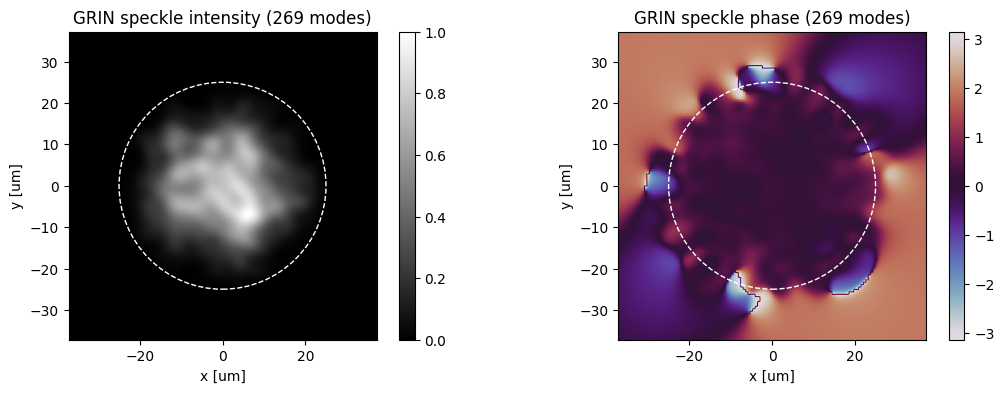

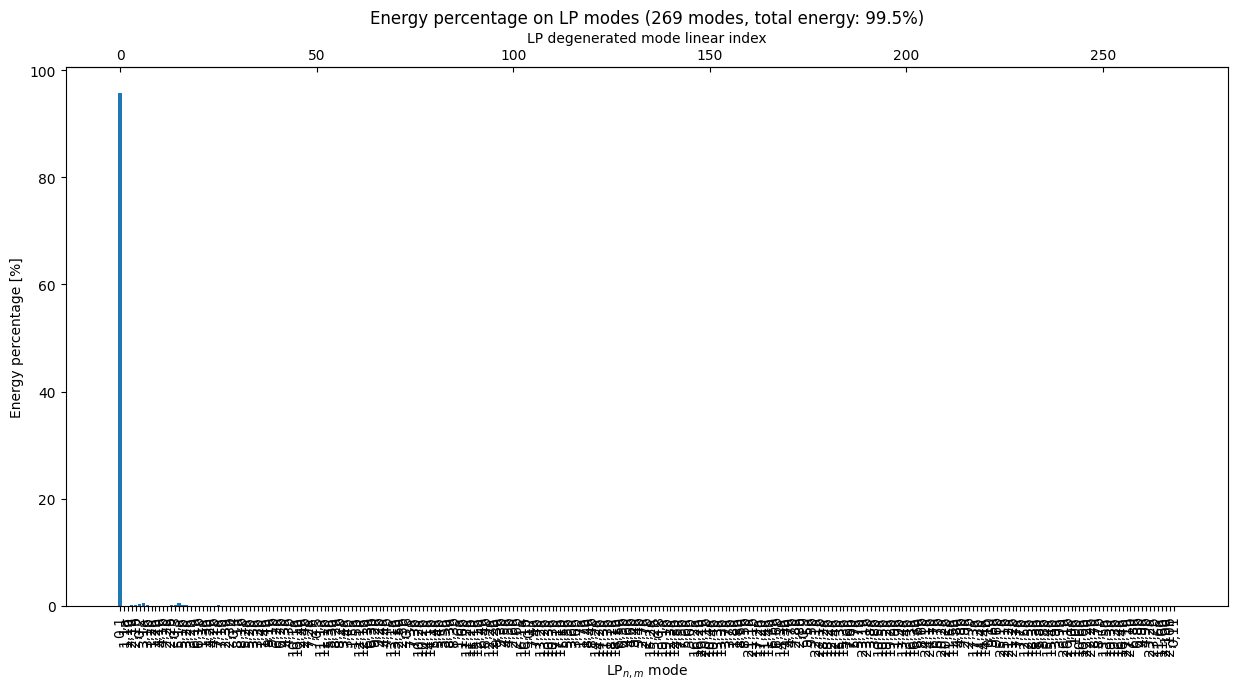

In [160]:
best_coupled_out = get_output_field_from_phases(solution, propagation_matrix)
print(pearson(np.square(np.abs(best_coupled_out.field)), np.square(np.abs(target_field))))
# best_coupled_out = get_output_field_from_phases(phi0.flatten(), propagation_matrix)
best_coupled_out.plot(complex=True, complex_hsv=False)
best_coupled_out.plot_coefficients()

Now let's create the propagation matrix with no mode energy exchange, this matrix is diagonal.
Then compute the new modes coefficients. Only their phases should have changed.

### Fourier transform the output speckle after padding it

(2048, 2048)
(2048, 2048)


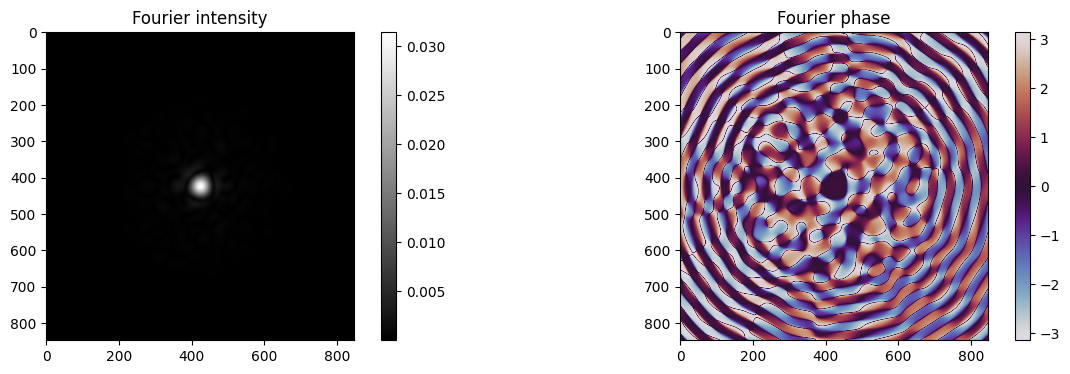

In [161]:
speckle = best_coupled_out.field
pad_amount = (grid_length_fourier - grid_length) // 2
padded_speckle = np.pad(speckle, pad_width=pad_amount)
print(padded_speckle.shape)

speckle_fourier = fourier_transform(padded_speckle)
print(speckle_fourier.shape)

win = slice(600, -600)

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].set_title('Fourier intensity')
pl0 = axs[0].imshow(np.abs(speckle_fourier[win, win]), cmap='gray')
plt.colorbar(pl0, ax=axs[0])

axs[1].set_title('Fourier phase')
pl1 = axs[1].imshow(np.angle(speckle_fourier[win, win]), cmap='twilight')
plt.colorbar(pl1, ax=axs[1])

### Export for Matlab